In this notebook, we are going to look at the normalized difference vegetation index (NDVI) development over time in Khan Yunis. Khan Yunis is in Gaza, and the main goal of this assignment is to discover how the Siege of Khan Yunis has impacted the greenness of the city. From the news we could see that many citizens are displaced from their homes by the constant bombing.

# Installations and libraries

In [1]:
# Import packages
import osgeo
from os.path import join as pjoin
import pandas as pd
import numpy as np
import xarray as xr
import xrspatial as xrs
import rioxarray
import contextily as ctx 

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Polygon
import datashader as ds

import planetary_computer as pc
import pystac
from pystac_client import Client
import planetary_computer
import requests
import stackstac
from pystac import ItemCollection

import rich.table
import dask.diagnostics

from rich.table import Table
from rich.console import Console

import matplotlib.dates as mdates
from collections import defaultdict
from matplotlib.colors import BoundaryNorm, LinearSegmentedColormap
from matplotlib.ticker import MaxNLocator
from numpy.ma import masked_inside

In [2]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

# Get Planetary data

In [3]:
# Define the polygon coordinates
polygon_coordinates = [
    [
        [34.285989364364525, 31.380851319389052],  # Coordinate 1
        [34.25234373497887, 31.351829624631897],   # Coordinate 2
        [34.33954771318251, 31.30520027736415],    # Coordinate 3
        [34.36598356484268, 31.336582317220593],   # Coordinate 4
        [34.285989364364525, 31.380851319389052]   # Closing the polygon by repeating the first point
    ]
]



# Define the datetime range
daterange = {"interval": ["2018-04-06T23:59:59Z", "2024-04-06T23:59:59Z"]}



# Open the STAC catalog
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

# Perform the search using CQL2-JSON filter
search = catalog.search(
    filter_lang="cql2-json",
    filter={
        "op": "and",
        "args": [
            {"op": "s_intersects", "args": [{"property": "geometry"}, {"type": "Polygon", "coordinates": polygon_coordinates}]},
            {"op": "anyinteracts", "args": [{"property": "datetime"}, daterange]},
            {"op": "=", "args": [{"property": "collection"}, "sentinel-2-l2a"]},
            {"op": "<=", "args": [{"property": "eo:cloud_cover"}, 12]}
        ]
    }
)

# Fetch items
items = list(search.get_items())
print(f"Found {len(items)} items")

Found 266 items


In [4]:
# Assuming 'items' is a list of STAC Item objects or similar
signed_items = [planetary_computer.sign(item) for item in items]

ds = stackstac.stack(
    signed_items,
    epsg=32636,
    resolution=(10, 10)
)

# EPSG 32636 is the code of Gaza 

/opt/anaconda3/envs/environment/lib/python3.11/site-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


# Data processing

In [5]:
print('Number of time steps equals: ', len(ds.time))
print('The bands in this satellite data are: ', ds.band.values)
ds

Number of time steps equals:  266
The bands in this satellite data are:  ['AOT' 'B01' 'B02' 'B03' 'B04' 'B05' 'B06' 'B07' 'B08' 'B09' 'B11' 'B12'
 'B8A' 'SCL' 'WVP' 'visual' 'preview']


<xarray.DataArray 'stackstac-5356aee68c3fec8edadd7c0c1f3bce29' (time: 266,
                                                                band: 17,
                                                                y: 11303,
                                                                x: 11304)> Size: 5TB
dask.array<fetch_raster_window, shape=(266, 17, 11303, 11304), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/46)
  * time                                     (time) datetime64[ns] 2kB 2018-0...
    id                                       (time) <U54 57kB 'S2A_MSIL2A_201...
  * band                                     (band) <U7 476B 'AOT' ... 'preview'
  * x                                        (x) float64 90kB 5.99e+05 ... 7....
  * y                                        (y) float64 90kB 3.502e+06 ... 3...
    s2:reflectance_conversion_factor         (time) float64 2kB 0.9954 ... 1.002
    ...                                       ...
    proj:shape                               (band) object 136B [10980, 10980...
    title                                    (band) <U37 3kB 'Aerosol optical...
    common_name                              (band) object 136B None ... None
    center_wavelength                        (band) object 136B None ... None
    full_width_half_max                      (band) object 136B None ... None
    epsg                                     int64 8B 32636
Attributes:
    spec:        RasterSpec(epsg=32636, bounds=(598960, 3388660, 712000, 3501...
    crs:         epsg:32636
    transform:   | 10.00, 0.00, 598960.00|\n| 0.00,-10.00, 3501690.00|\n| 0.0...
    resolution:  10

Looks good, we are going to continue with it.

In [14]:
xmin, xmax, ymin, ymax = 619120, 629950, 3464201, 3472526 # UTM Coordinates
Khan_Yunis = ds.loc[:,:, ymax:ymin,xmin:xmax]
print('Number of time steps equals: ', len(Khan_Yunis.time))
print('The bands in this satellite data are: ', Khan_Yunis.band.values)
Khan_Yunis

Number of time steps equals:  258
The bands in this satellite data are:  ['AOT' 'B01' 'B02' 'B03' 'B04' 'B05' 'B06' 'B07' 'B08' 'B09' 'B11' 'B12'
 'B8A' 'SCL' 'WVP' 'visual' 'preview']


<xarray.DataArray 'stackstac-7dfdab66053b0838f5528e93db6d564f' (time: 258,
                                                                band: 17,
                                                                y: 832, x: 1084)>
dask.array<getitem, shape=(258, 17, 832, 1084), dtype=float64, chunksize=(1, 1, 677, 1024), chunktype=numpy.ndarray>
Coordinates: (12/46)
  * time                                     (time) datetime64[ns] 2018-04-16...
    id                                       (time) <U54 'S2A_MSIL2A_20180416...
  * band                                     (band) <U7 'AOT' ... 'preview'
  * x                                        (x) float64 6.191e+05 ... 6.3e+05
  * y                                        (y) float64 3.473e+06 ... 3.464e+06
    s2:thin_cirrus_percentage                (time) float64 0.6128 ... 0.005179
    ...                                       ...
    proj:transform                           (band) object [10.0, 0.0, 600000...
    gsd                                      (band) object 10.0 60.0 ... None
    common_name                              (band) object None ... None
    center_wavelength                        (band) object None 0.443 ... None
    full_width_half_max                      (band) object None 0.027 ... None
    epsg                                     int64 32636
Attributes:
    spec:        RasterSpec(epsg=32636, bounds=(598960, 3388660, 712000, 3501...
    crs:         epsg:32636
    transform:   | 10.00, 0.00, 598960.00|\n| 0.00,-10.00, 3501690.00|\n| 0.0...
    resolution:  10

Now do the lazy operation, and we see that we significantly decreased the size of our dataset because we neglet all the other bands.

In [9]:
red = Khan_Yunis.sel(band='B04')
nir = Khan_Yunis.sel(band='B08')
ndvi = (nir - red) / (nir + red)

monthly = ndvi.resample(time="MS").max("time", keep_attrs=True)

print('Number of time steps equals: ', len(monthly.time))
monthly

Number of time steps equals:  73


<xarray.DataArray 'stackstac-ee13cab82b58503d0f70e62080c1b8ef' (time: 73,
                                                                y: 832, x: 1084)>
dask.array<where, shape=(73, 832, 1084), dtype=float64, chunksize=(2, 677, 1024), chunktype=numpy.ndarray>
Coordinates: (12/17)
  * x                                        (x) float64 6.191e+05 ... 6.3e+05
  * y                                        (y) float64 3.473e+06 ... 3.464e+06
  * time                                     (time) datetime64[ns] 2018-04-01...
    sat:orbit_state                          <U10 'descending'
    sat:relative_orbit                       int64 121
    s2:product_type                          <U7 'S2MSI2A'
    ...                                       ...
    s2:datatake_type                         <U8 'INS-NOBS'
    proj:bbox                                object [600000.0, 3390240.0, 709...
    proj:transform                           object [10.0, 0.0, 600000.0, 0.0...
    proj:shape                               object [10980, 10980]
    gsd                                      object 10.0
    epsg                                     int64 32636

In [10]:
#with dask.diagnostics.ProgressBar():
#    Khan_Yunis_computed = monthly.compute()

For now we can skip the calculation since it took a significant amount of time and we have done it once already. It took about 30 minutes then to run. To still work with the data we can load in a NumPy file which I saved last time. This was the result of the compute function. It was an xarray but I created two seperate arrays, one for timestamps and one for the NVDI data and then joined them together to create this array.

In [3]:
file = '/Users/aymanelhattache/Desktop/School /UU - ADS/P3 Spatial data Machine learning/Term project/Khan_Yunis_computed.npy/Khan_Yunis_computed.npy'
Khan_Yunis_computed = np.load(file)
# Khan_Yunis_computed

# Data analysation and visualisation

## NDVI plot

We are interested in the months November to April, as these are the months that could have impact from the war. We created a custom map with black (inspired by some news articles) because this helps with interpretation we believe. The map that gave us inspiration was; https://forensic-architecture.org/investigation/ecocide-in-gaza

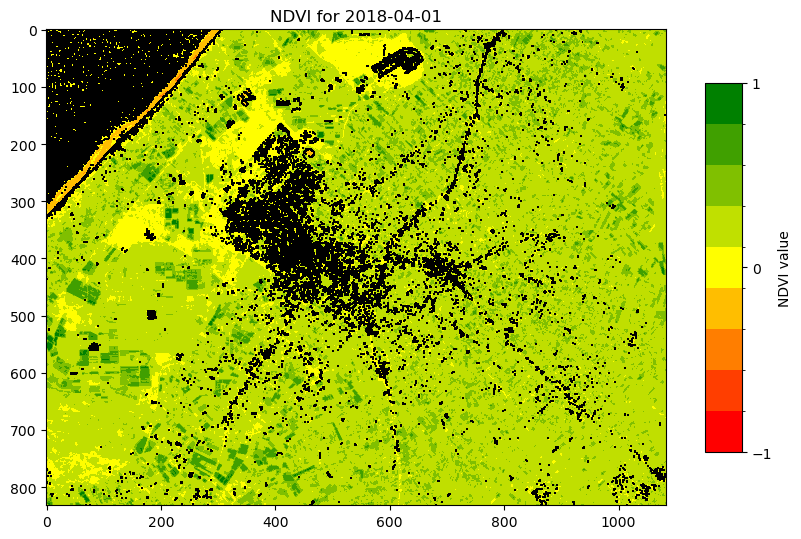

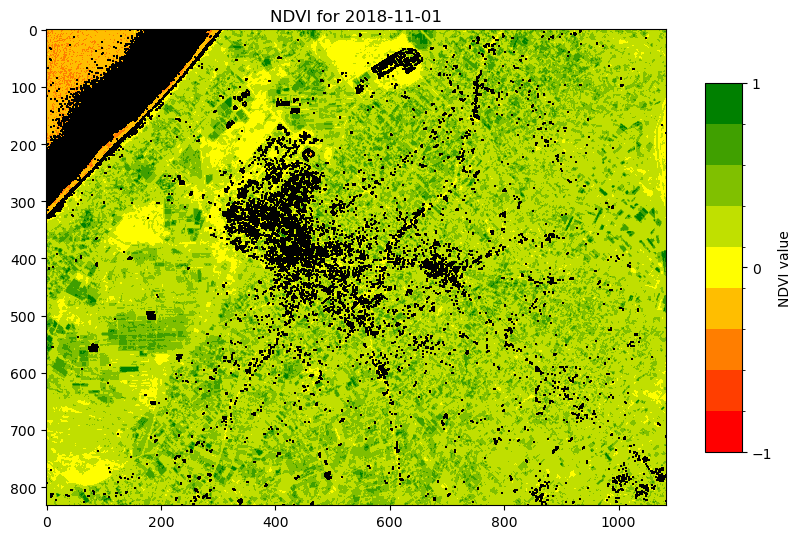

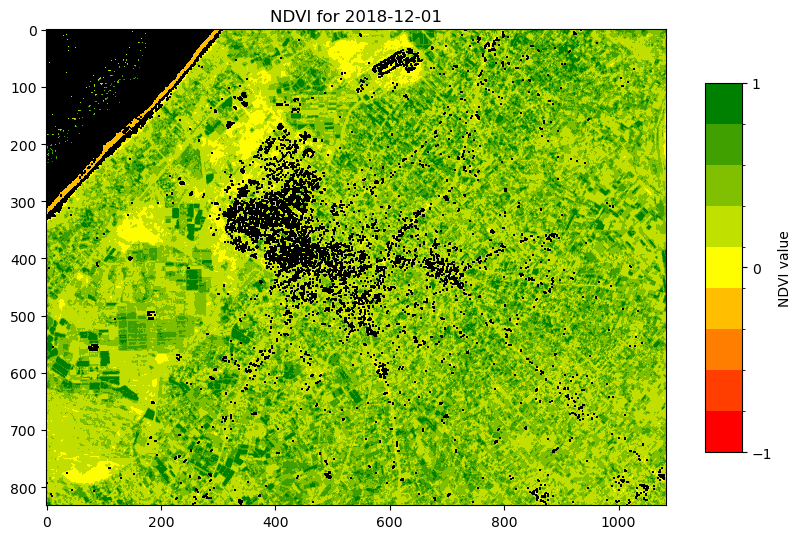

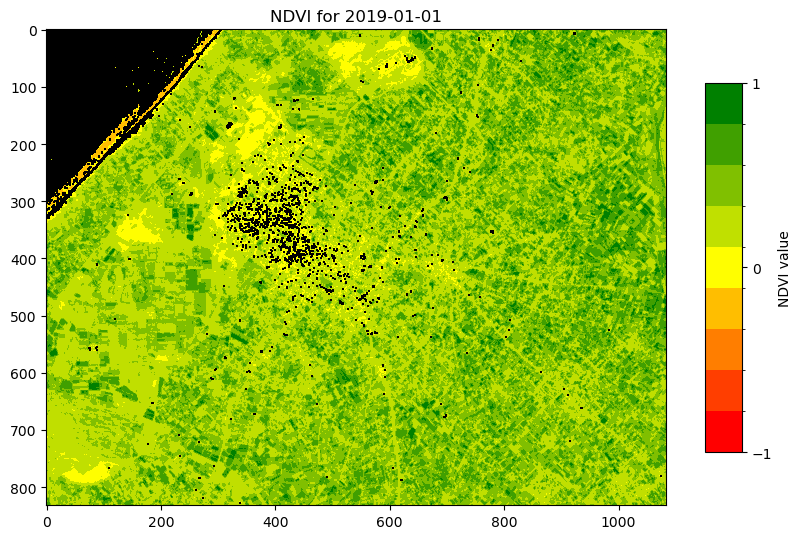

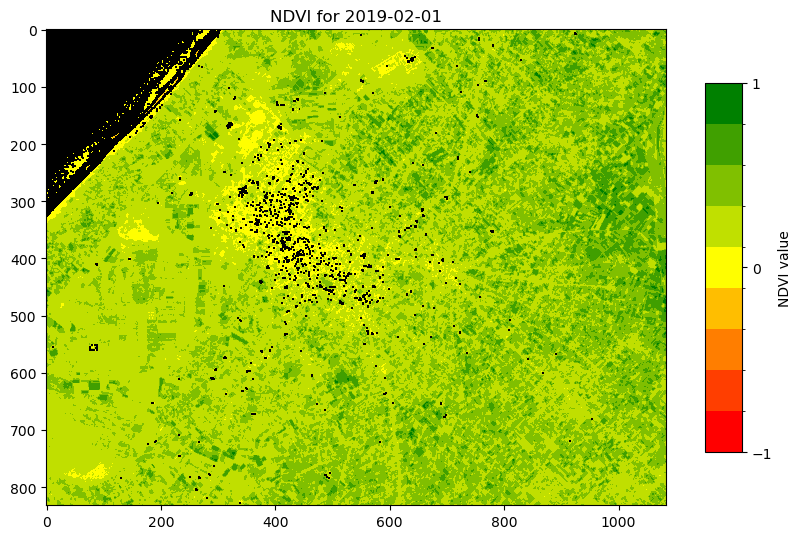

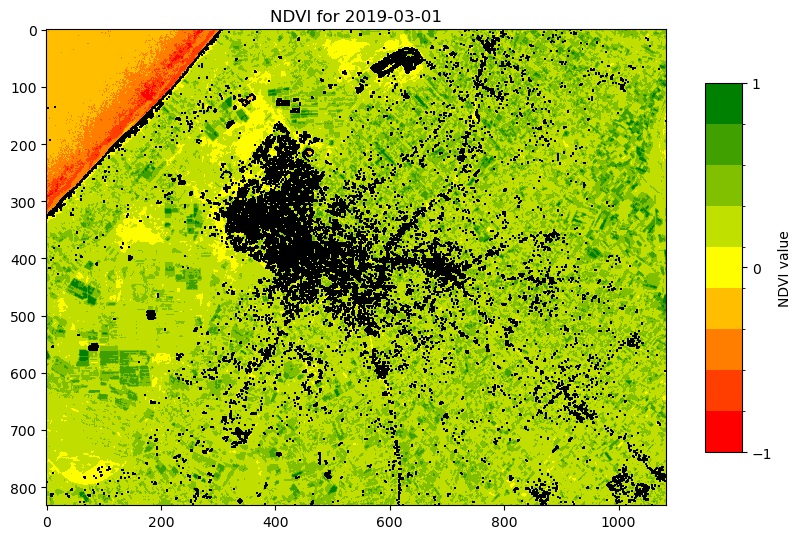

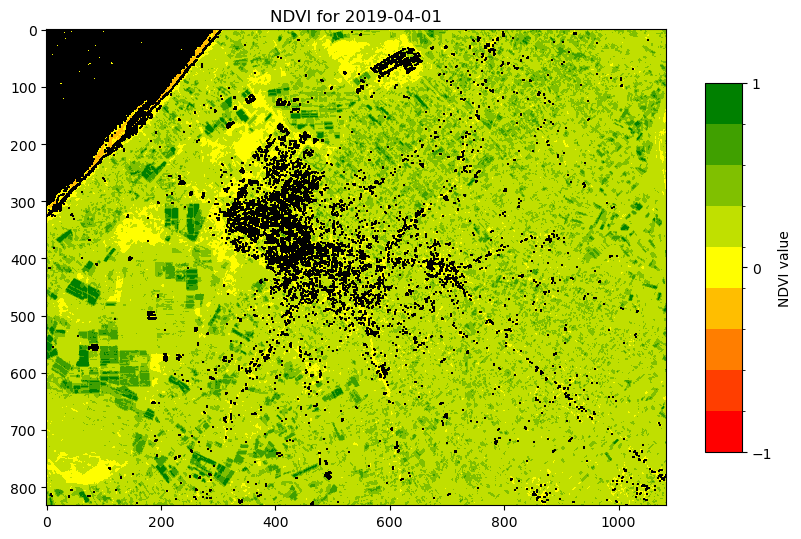

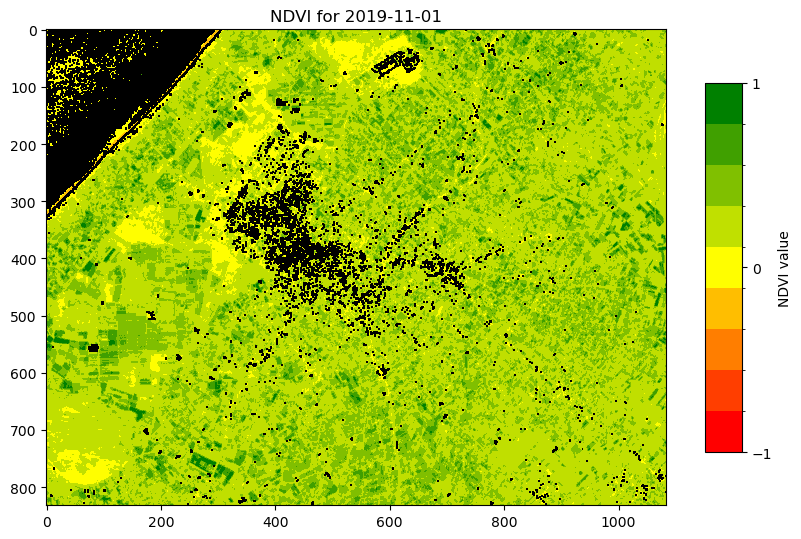

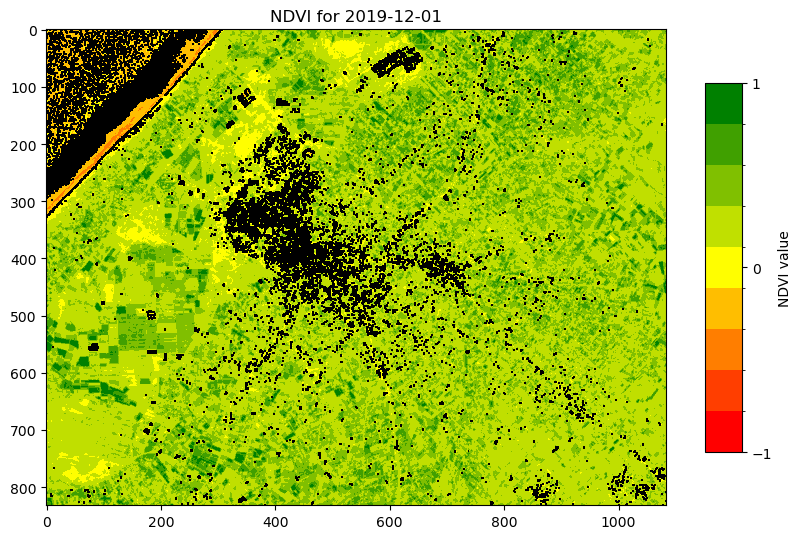

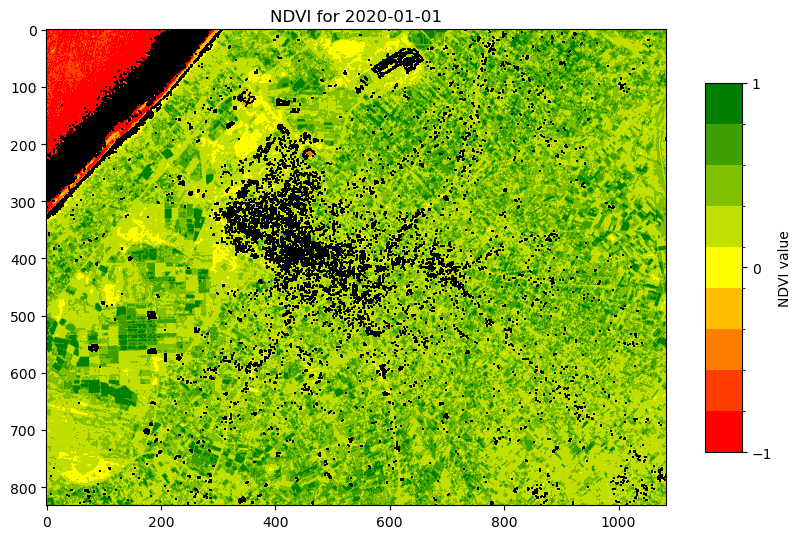

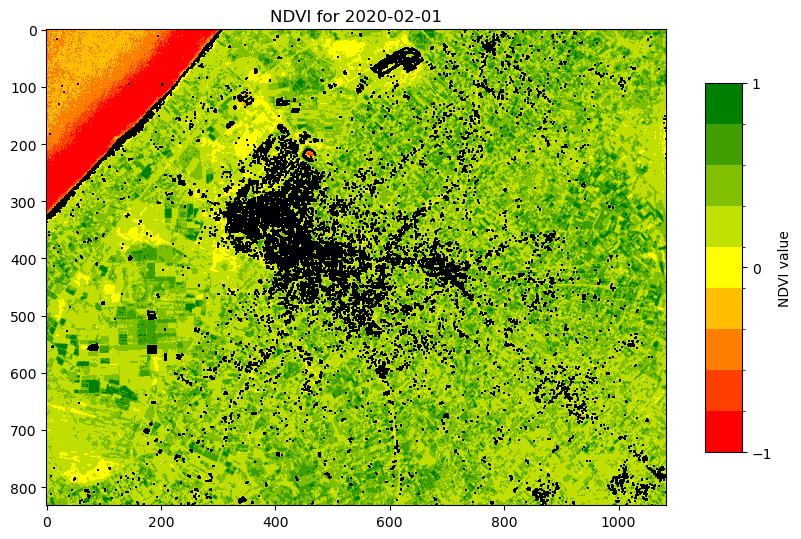

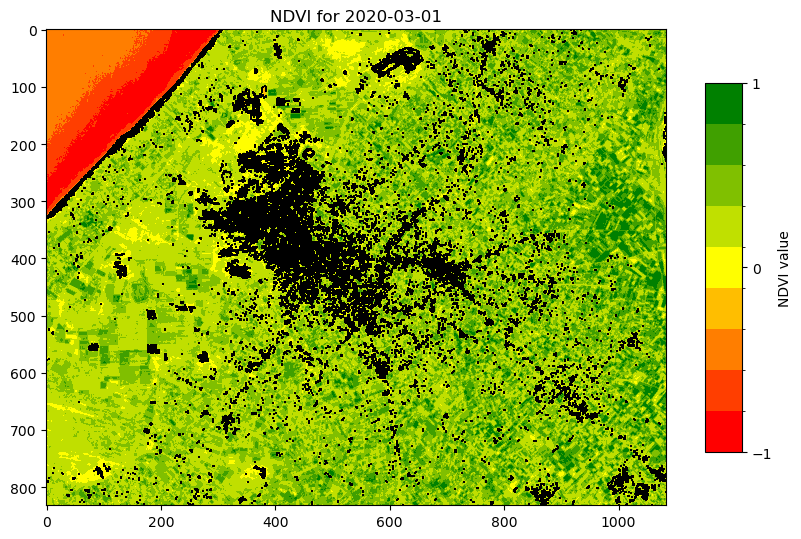

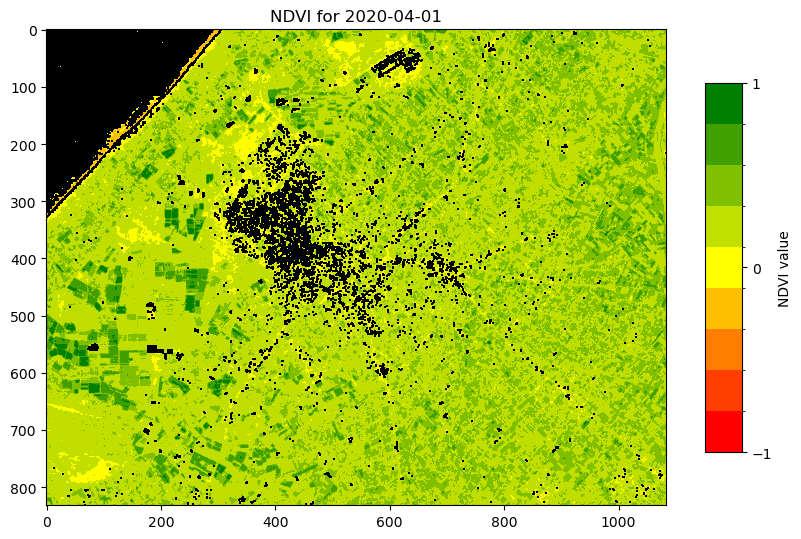

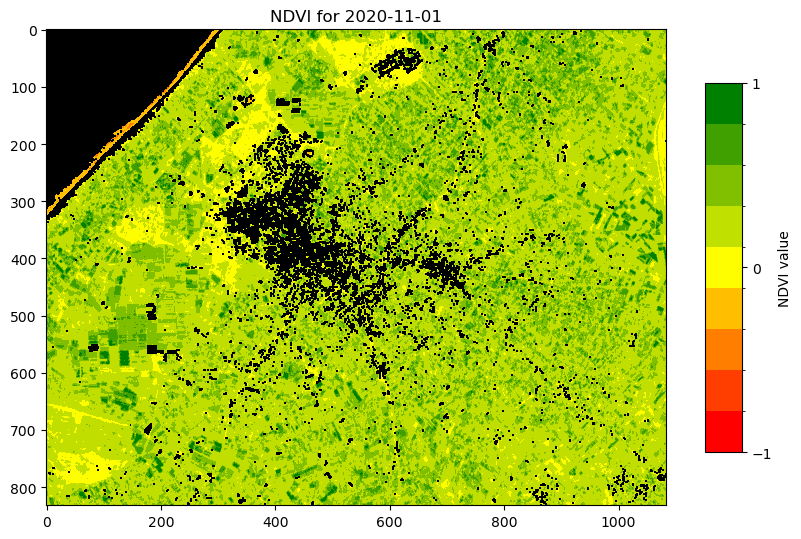

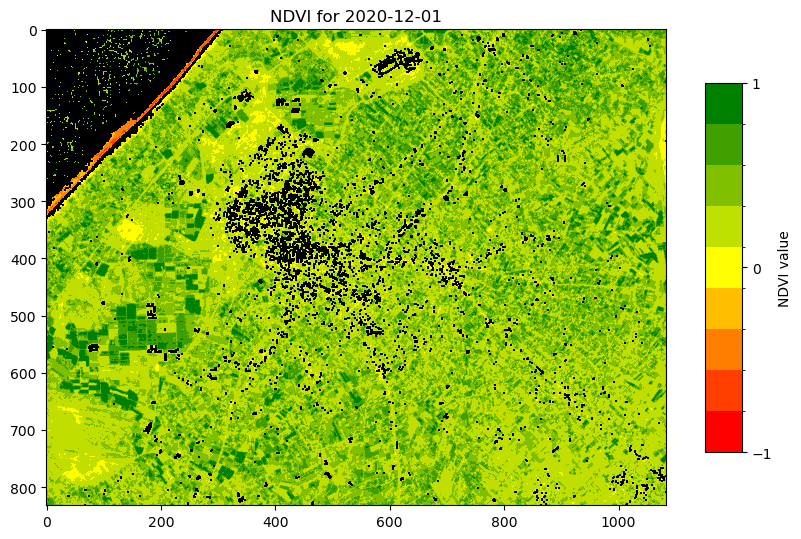

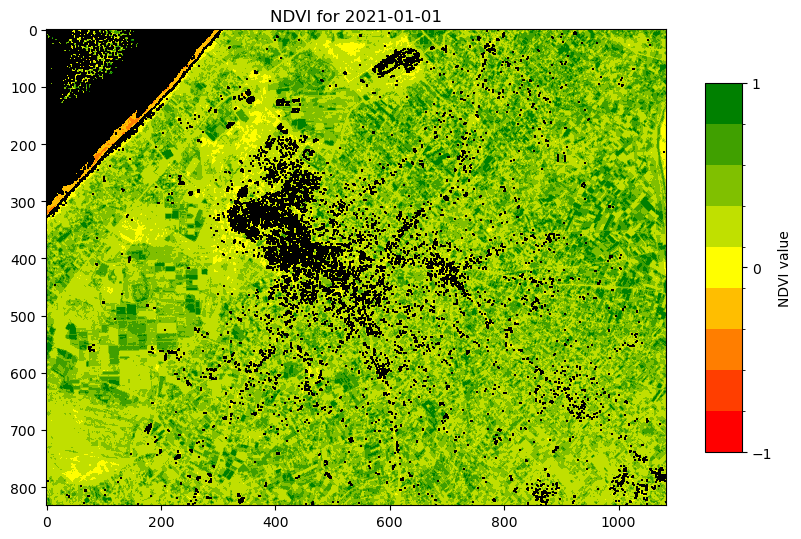

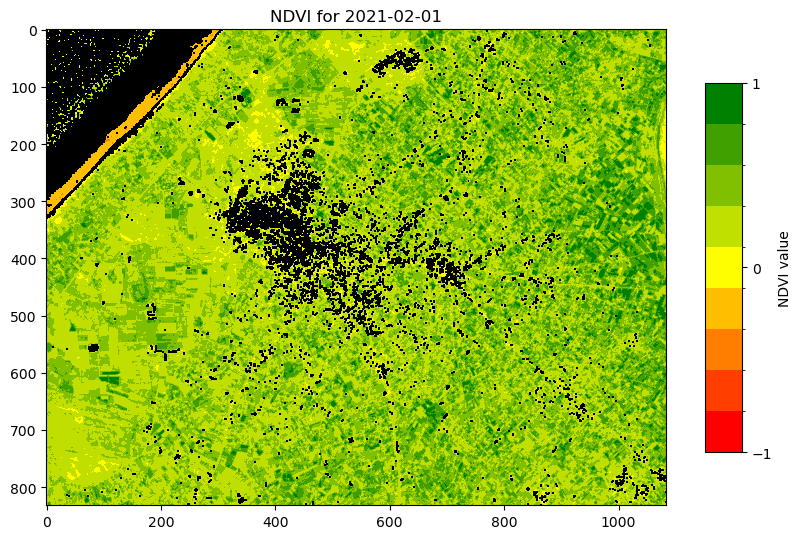

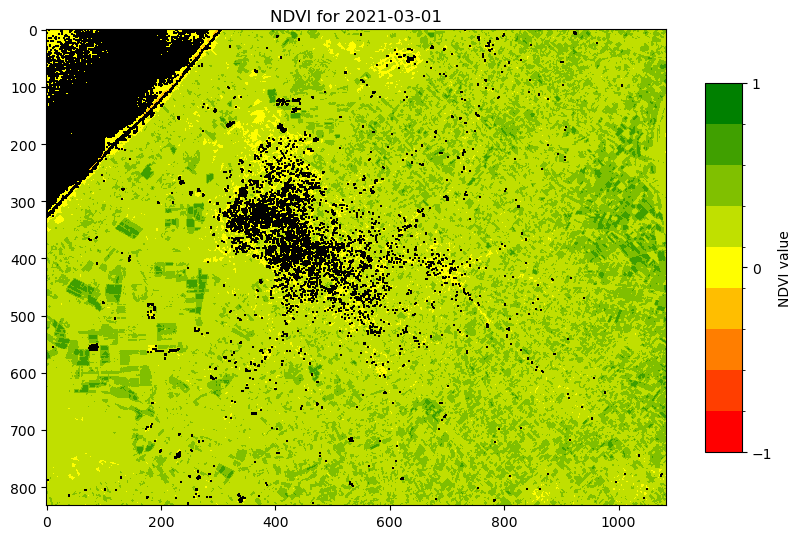

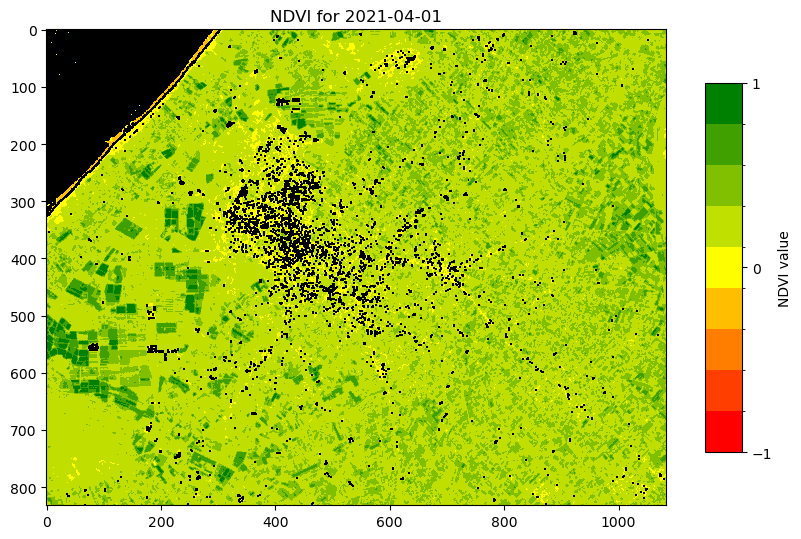

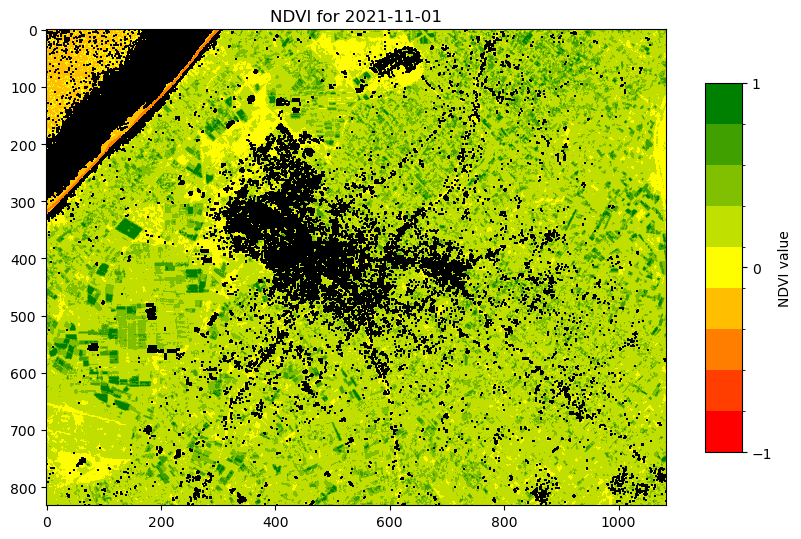

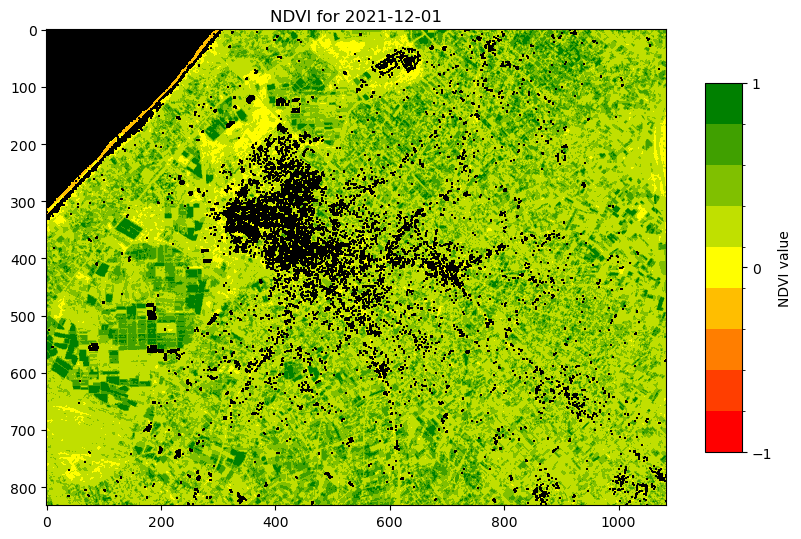

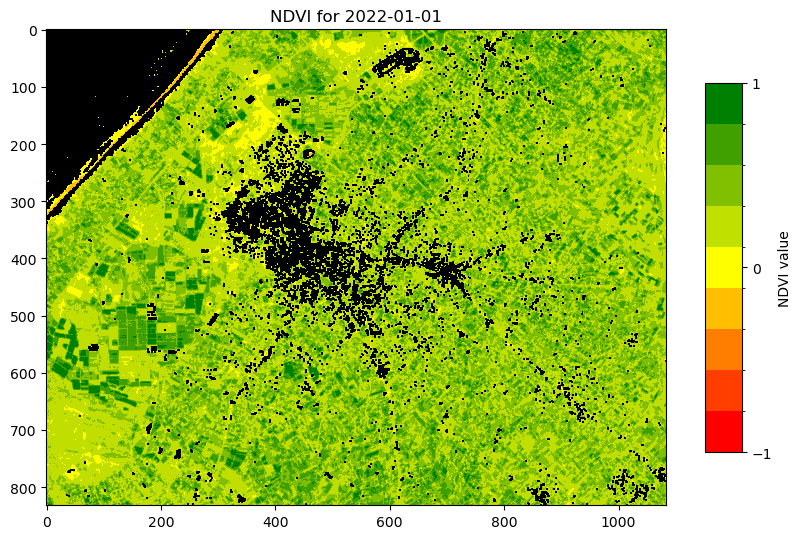

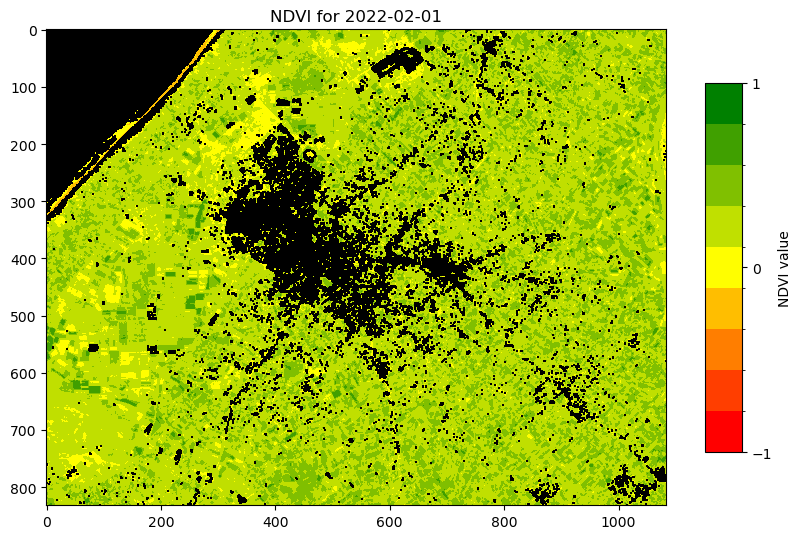

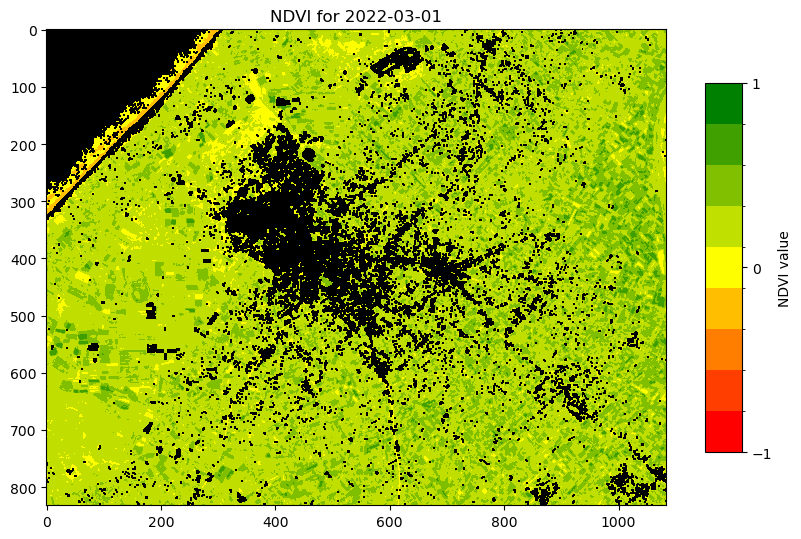

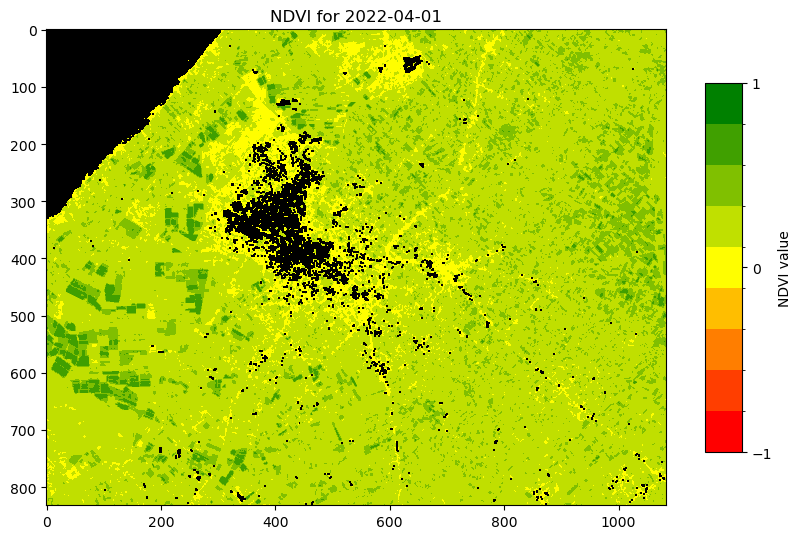

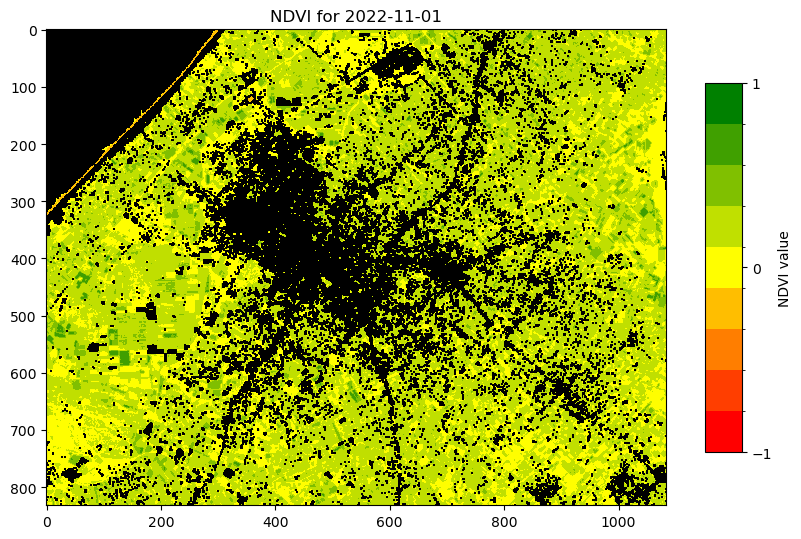

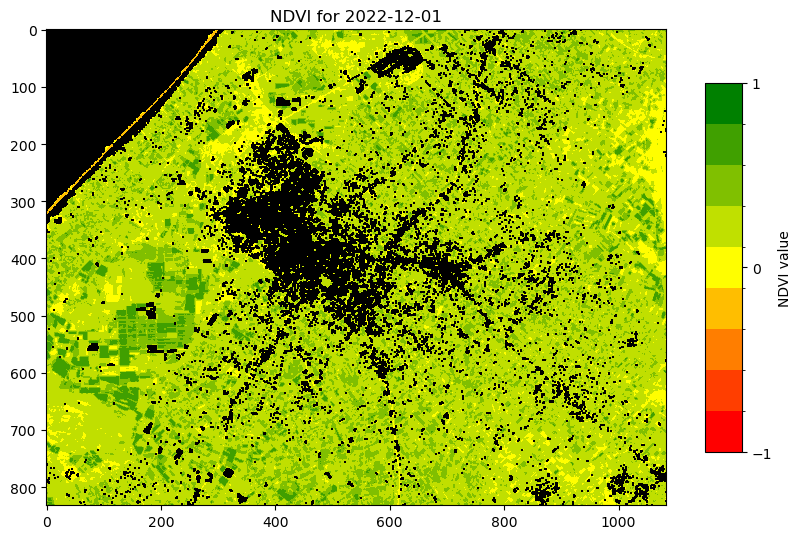

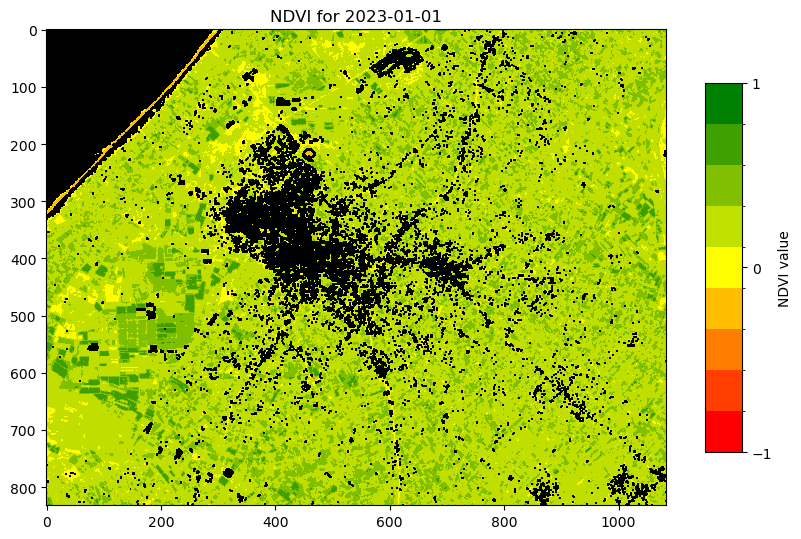

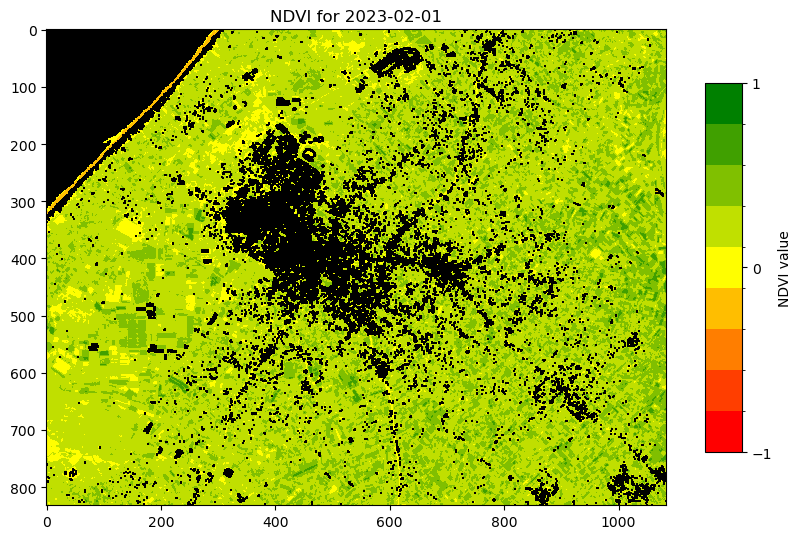

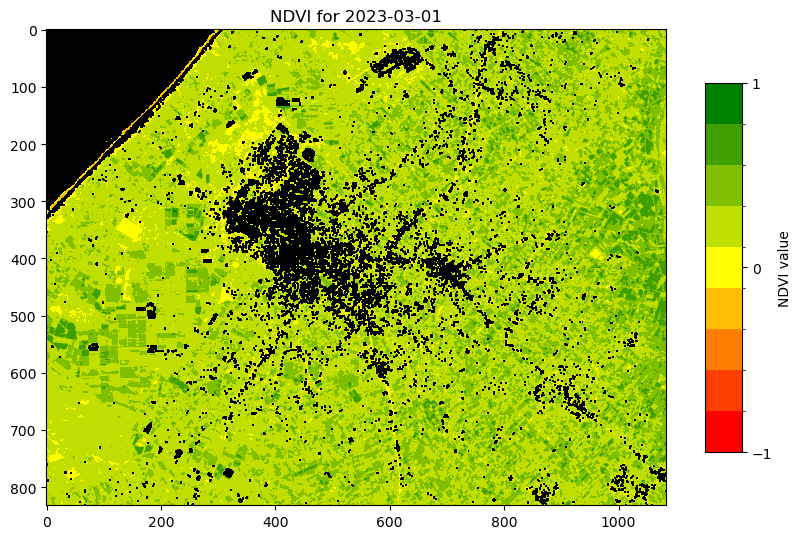

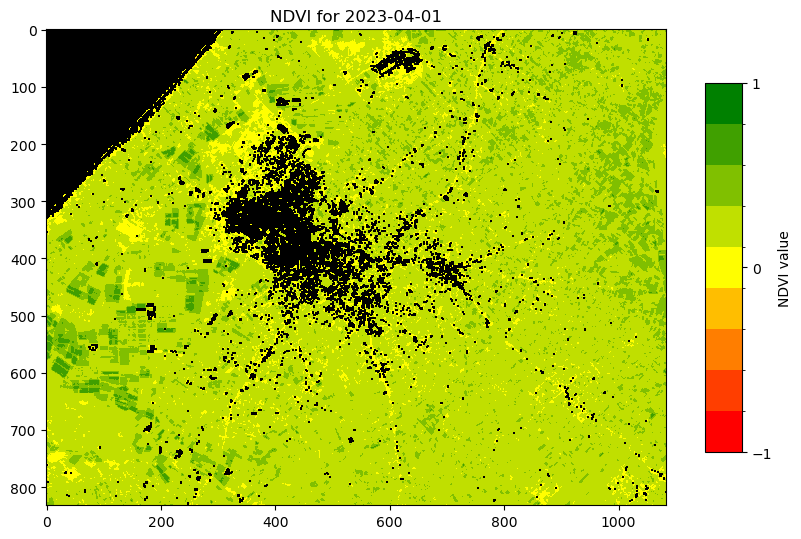

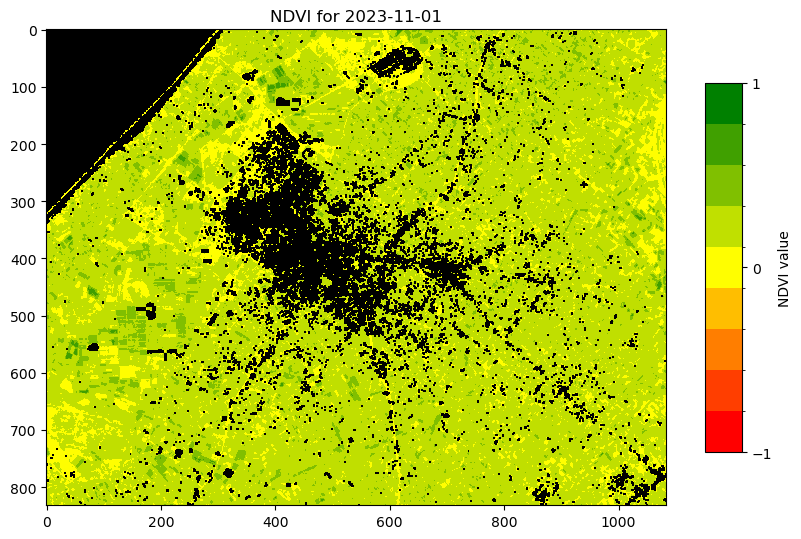

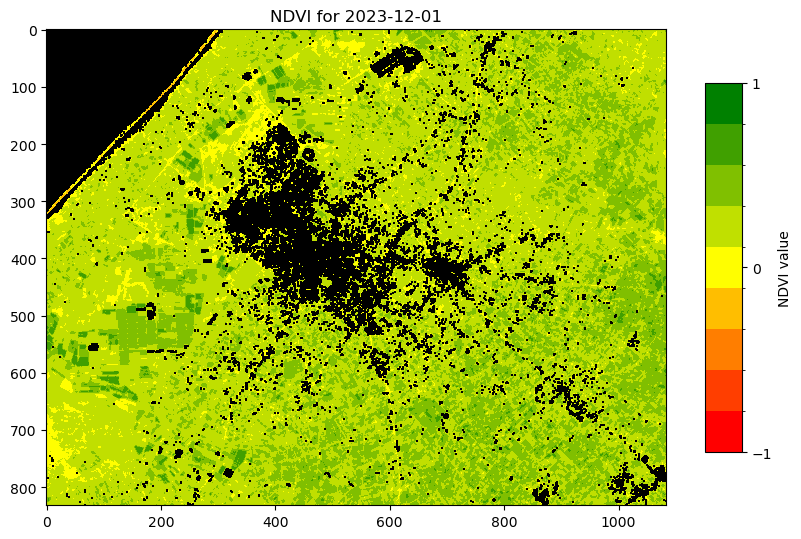

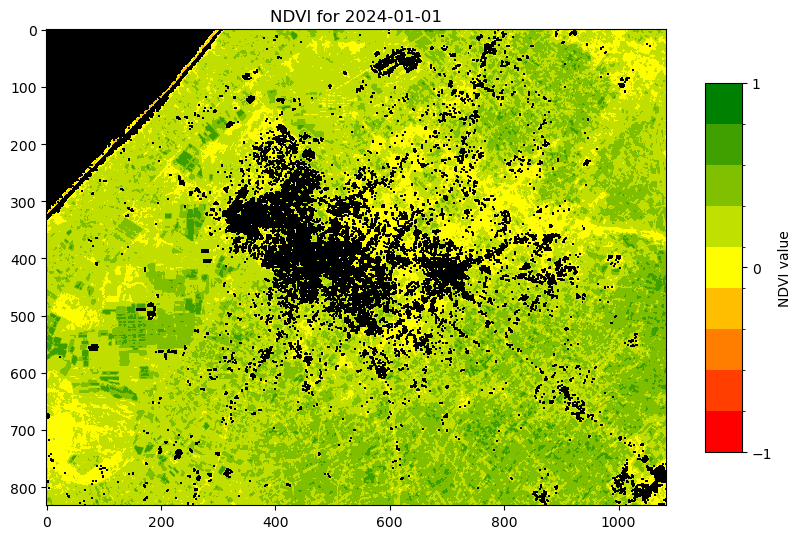

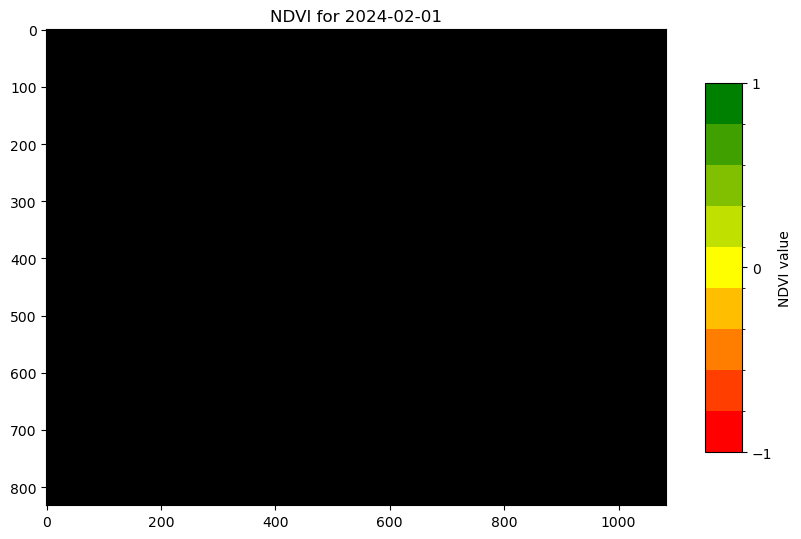

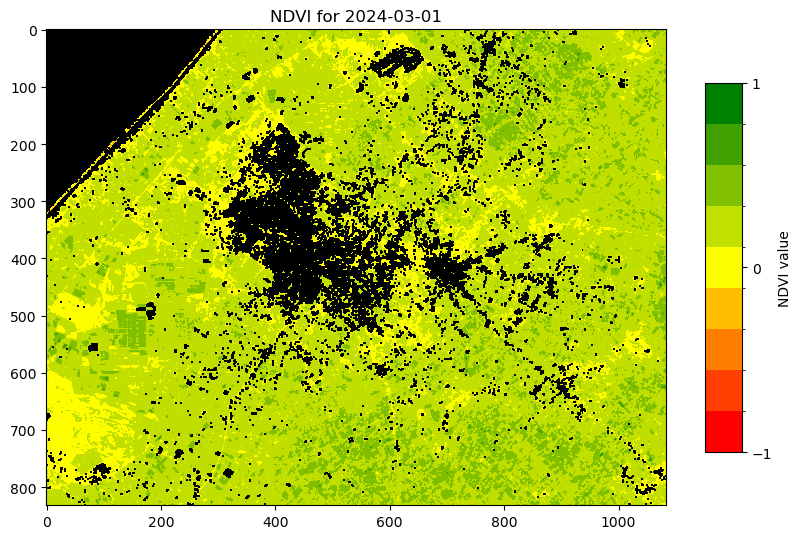

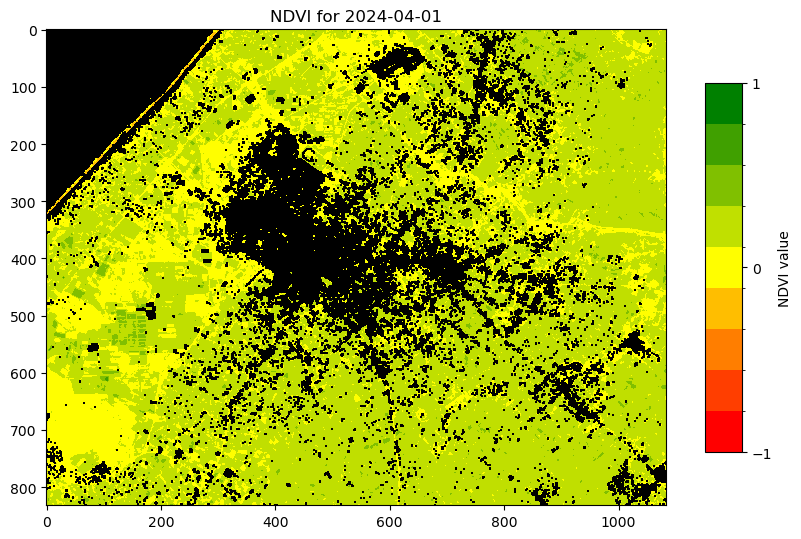

In [4]:
# creation of our customized map based on the article 
colors = ['red', 'yellow', 'green']
cmap_name = 'customRdYlGn'
ndvi_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)
ndvi_cmap.set_bad('black')


for i in range(Khan_Yunis_computed.shape[0]):
    timestamp = np.datetime64(Khan_Yunis_computed['timestamp'][i, 0, 0], 'D')
    month = timestamp.astype('datetime64[M]').astype(int) % 12 + 1

    if month in [11, 12, 1, 2, 3, 4]:
        ndvi_slice = Khan_Yunis_computed['ndvi'][i, :, :]
        masked_ndvi_slice = masked_inside(ndvi_slice, -0.05, 0.05)  # masked values, could be adjusted
        ndvi_bounds = np.linspace(-1, 1, 10)
        norm = BoundaryNorm(ndvi_bounds, ncolors=256) # normalization
        plt.figure(figsize=(10, 8))
        img = plt.imshow(masked_ndvi_slice, cmap=ndvi_cmap, norm=norm)
        cbar = plt.colorbar(img, spacing='proportional', ticks=MaxNLocator(integer=True), shrink=0.6, aspect=10)
        cbar.set_label('NDVI value')
        cbar.ax.tick_params(labelsize=10)
        plt.tick_params(axis='both', which='major', labelsize=10)
        plt.title(f'NDVI for {timestamp}')
        plt.show()
        plt.close()

## NDVI differences

With these figures we want to asses the differences between 'normal periods' and not normal periods. With the 'normal periods' we want to create a baseline, so to speak. 

After we have this baseline, we can compare the data during the war (November 2023 - onwards) to this baseline to see how much this differs. What is important in here is that we create a baseline for each month, as there is a seasonality in NDVI values, with peaks around December/November and lows in July.

Before we start this baseline, let's first do some data exploration to see the data what we are working with.

In [52]:
monthly_ndvi_totals = defaultdict(lambda: defaultdict(list))

for i in range(Khan_Yunis_computed.shape[0]):
    timestamp = np.datetime64(Khan_Yunis_computed['timestamp'][i, 0, 0], 'D')
    year = timestamp.astype('datetime64[Y]').astype(int) + 1970
    month_num = timestamp.astype('datetime64[M]').astype(int) % 12 + 1
    monthly_ndvi_totals[year][month_num].append(Khan_Yunis_computed['ndvi'][i].sum())

# monthly_ndvi_totals

In [19]:
for year, months in monthly_ndvi_totals.items():
    for month, values in months.items():
        monthly_ndvi_totals[year][month] = np.sum(values)

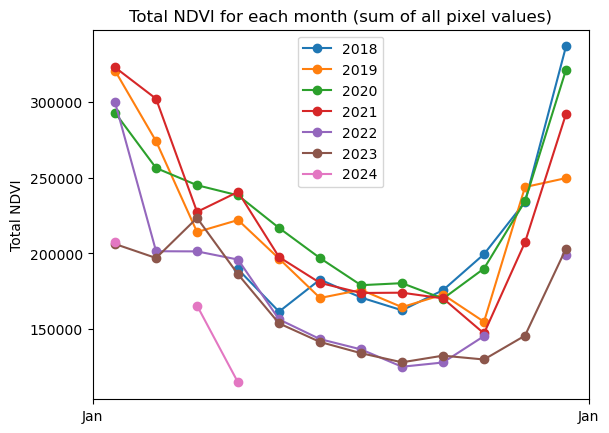

In [51]:
# make visualization 
plot_data = defaultdict(list)
for year in sorted(monthly_ndvi_totals):
    for month in range(1, 13):
        if month in monthly_ndvi_totals[year]:
            plot_data[year].append((month, monthly_ndvi_totals[year][month]))

# line
fig, ax = plt.subplots()
for year, data in plot_data.items():
    data = sorted(data)
    months, total_ndvi = zip(*data)
    ax.plot(months, total_ndvi, marker='o', linestyle='-', label=str(year))

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.set_ylabel('Total NDVI')
ax.set_title('Total NDVI for each month (sum of all pixel values)')
ax.legend()
plt.show()

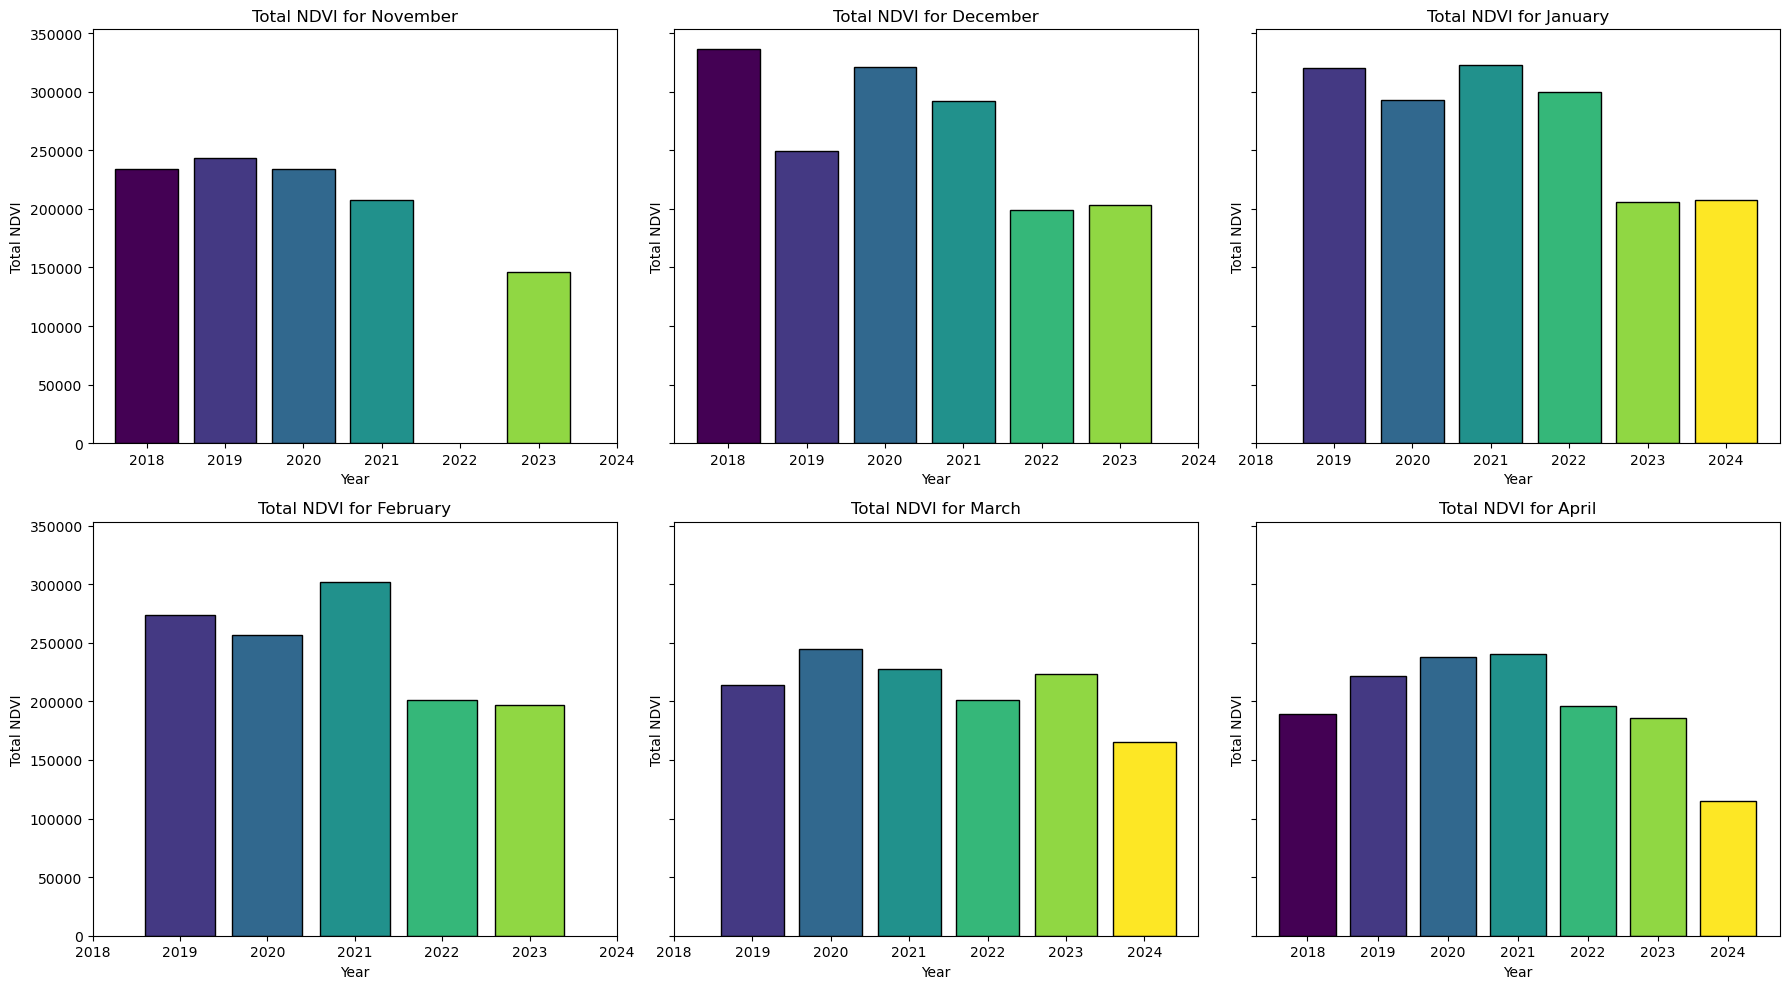

In [25]:
months_of_interest = [11, 12, 1, 2, 3, 4]  # our months of interest because of war
month_names = {11: 'November', 12: 'December', 1: 'January', 2: 'February', 3: 'March', 4: 'April'}
years = sorted(monthly_ndvi_totals.keys())

plot_data = defaultdict(lambda: defaultdict(list))
for year in years:
    for month in months_of_interest:
        plot_data[month][year] = monthly_ndvi_totals.get(year, {}).get(month, np.nan)

# Plot
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharey=True)
axes = axes.flatten()

for i, month in enumerate(months_of_interest):
    ax = axes[i]
    data = [(year, plot_data[month][year]) for year in sorted(plot_data[month])]
    if data:
        years, ndvi_totals = zip(*data)
        ax.bar(years, ndvi_totals, color=plt.cm.viridis(np.linspace(0, 1, len(years))), edgecolor='black')
        ax.set_title(f'Total NDVI for {month_names[month]}')
        ax.set_xlabel('Year')
        ax.set_ylabel('Total NDVI')
        ax.set_xticks(years)
        ax.set_xticklabels(years)

plt.tight_layout()
plt.show()

Besides looking at total NDVI (which is the sum of all Pixels) we can also look at mean, which is split in / amount of pixels.

In [57]:
monthly_ndvi_means = defaultdict(lambda: defaultdict(list))
for i in range(Khan_Yunis_computed.shape[0]):
    timestamp = np.datetime64(Khan_Yunis_computed['timestamp'][i, 0, 0], 'D')
    year = timestamp.astype('datetime64[Y]').astype(int) + 1970
    month_num = timestamp.astype('datetime64[M]').astype(int) % 12 + 1
    monthly_ndvi_means[year][month_num].append(Khan_Yunis_computed['ndvi'][i].mean())

In [59]:
for year, months in monthly_ndvi_means.items():
    for month, values in months.items():
        monthly_ndvi_means[year][month] = np.mean(values)

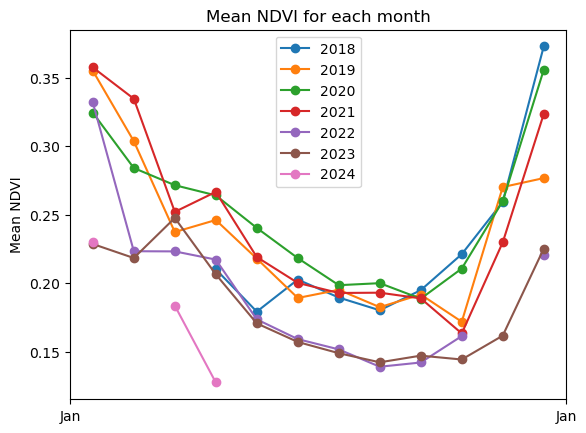

In [66]:
# plotting
plot_data = defaultdict(list)
for year in sorted(monthly_ndvi_means):
    for month in range(1, 13):
        if month in monthly_ndvi_means[year]:
            plot_data[year].append((month, monthly_ndvi_means[year][month]))

# make graph
fig, ax = plt.subplots()
for year, data in plot_data.items():
    data = sorted(data)  # Ensure the data is sorted by month
    months, mean_ndvi = zip(*data)  # Unpack months and NDVI values
    ax.plot(months, mean_ndvi, marker='o', linestyle='-', label=str(year))


ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.set_ylabel('Mean NDVI')
ax.set_title('Mean NDVI for each month')
ax.legend()
plt.show()

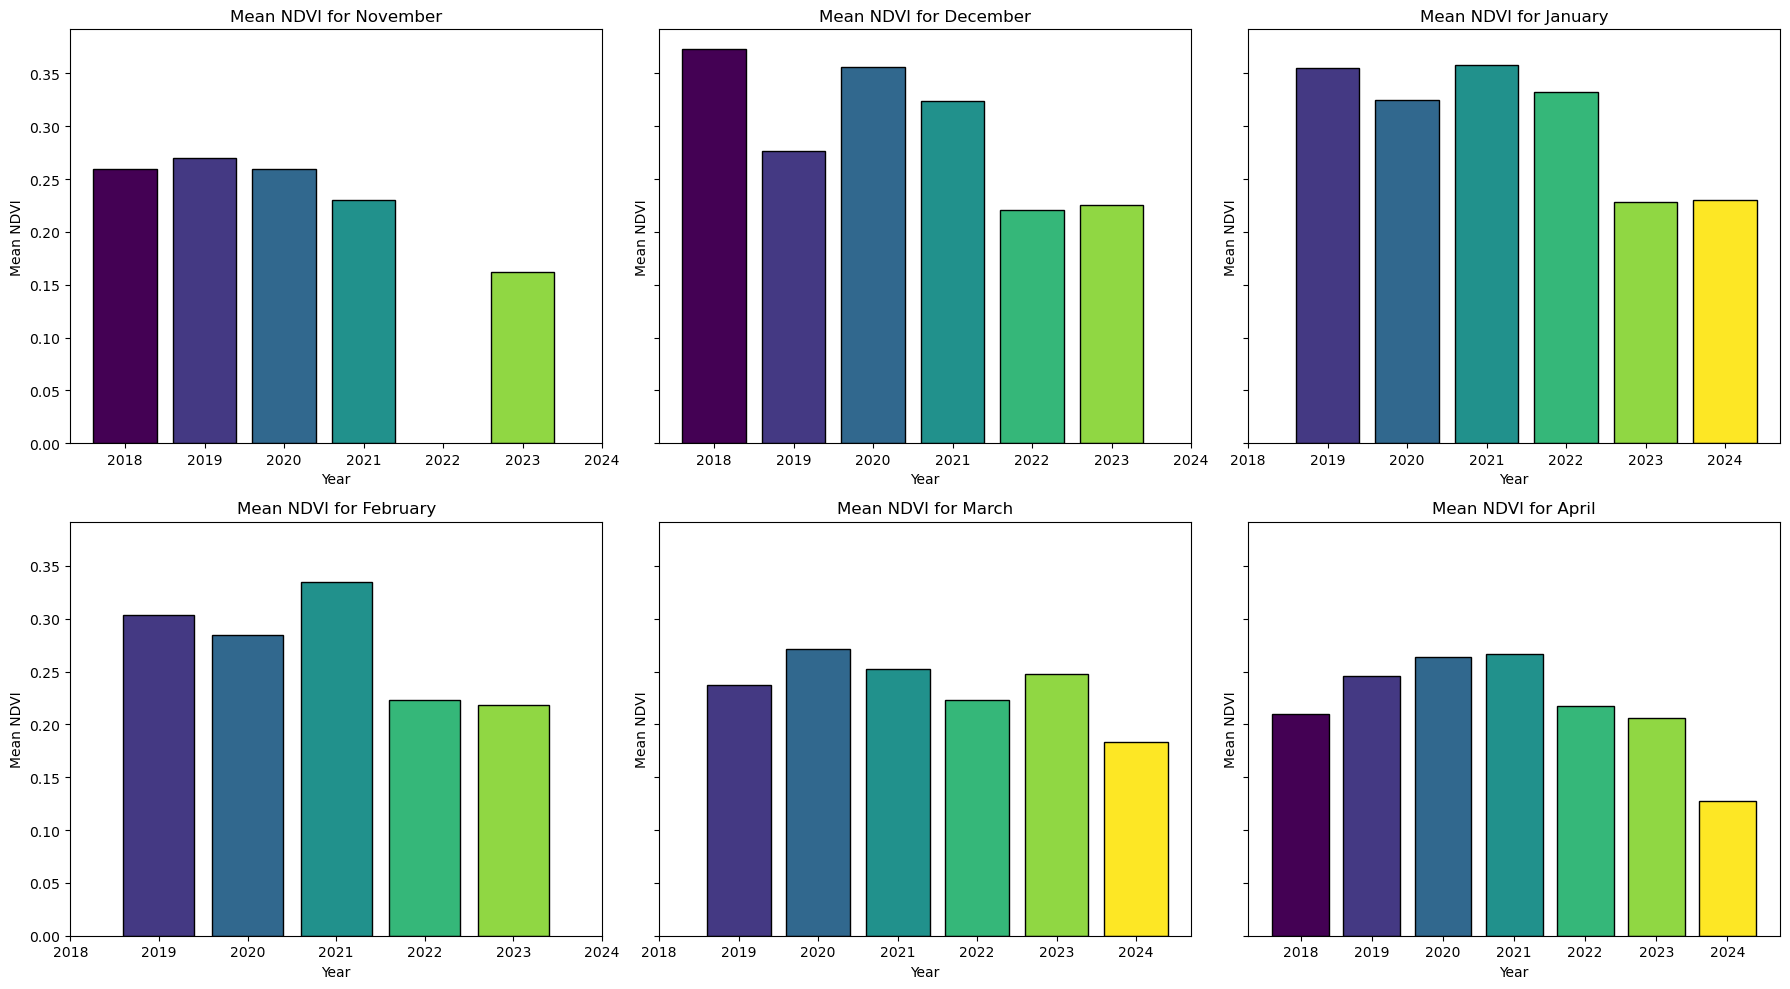

In [68]:
months_of_interest = [11, 12, 1, 2, 3, 4]  # 
month_names = {11: 'November', 12: 'December', 1: 'January', 2: 'February', 3: 'March', 4: 'April'}
years = sorted(monthly_ndvi_means.keys())


plot_data = defaultdict(lambda: defaultdict(list))
for year in years:
    for month in months_of_interest:
        plot_data[month][year] = monthly_ndvi_means.get(year, {}).get(month, np.nan)

# plot
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharey=True)
axes = axes.flatten()

for i, month in enumerate(months_of_interest):
    ax = axes[i]
    data = [(year, plot_data[month][year]) for year in sorted(plot_data[month])]
    if data:
        years, ndvi_means = zip(*data)
        ax.bar(years, ndvi_means, color=plt.cm.viridis(np.linspace(0, 1, len(years))), edgecolor='black')
        ax.set_title(f'Mean NDVI for {month_names[month]}')
        ax.set_xlabel('Year')
        ax.set_ylabel('Mean NDVI')
        ax.set_xticks(years)
        ax.set_xticklabels(years)

plt.tight_layout()
plt.show()

Based on our data exploration, we could see that between the war period, the NDVI was also fluctuating, likely because of different climates. 2020-2021 are greener than other years, and especially 2022 and 2023 are less green, very likely as a result of the drought across the mediterrenean.

In [29]:
ndvi_pre_siege = {'Nov': [], 'Dec': [], 'Jan': [], 'Feb': [], 'Mar': [], 'Apr': []}  # this will be our baseline. We only take the months that are relevant.
ndvi_siege = {'Nov': [], 'Dec': [], 'Jan': [], 'Feb': [], 'Mar': [], 'Apr': []}

def get_month_str(month_num):
    return {11: 'Nov', 12: 'Dec', 1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr'}.get(month_num, None) # makes it easier 

In [32]:
# for loop to get over each map in the array, and select only the useful months 
for i in range(Khan_Yunis_computed.shape[0]):
    timestamp = np.datetime64(Khan_Yunis_computed['timestamp'][i, 0, 0], 'D')
    year = timestamp.astype('datetime64[Y]').astype(int) + 1970
    month = timestamp.astype('datetime64[M]').astype(int) % 12 + 1
    month_str = get_month_str(month)
    
    # Skip if month is not in our interest
    if month_str is None:
        continue
    
    # here we create the baseline, everything in 'pre-siege'
    if year < 2023:
        ndvi_pre_siege[month_str].append(Khan_Yunis_computed['ndvi'][i, :, :])
    elif year == 2024 or (year == 2023 and month_str in ['Nov', 'Dec']):
        ndvi_siege[month_str].append(Khan_Yunis_computed['ndvi'][i, :, :])


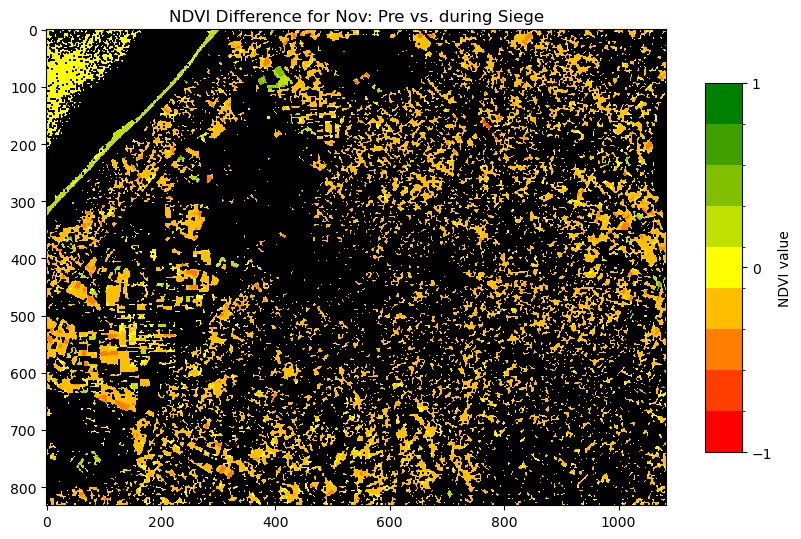

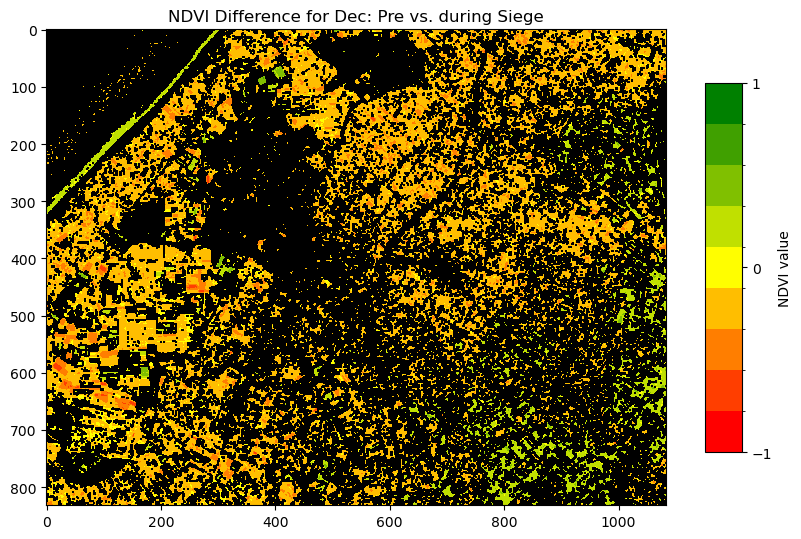

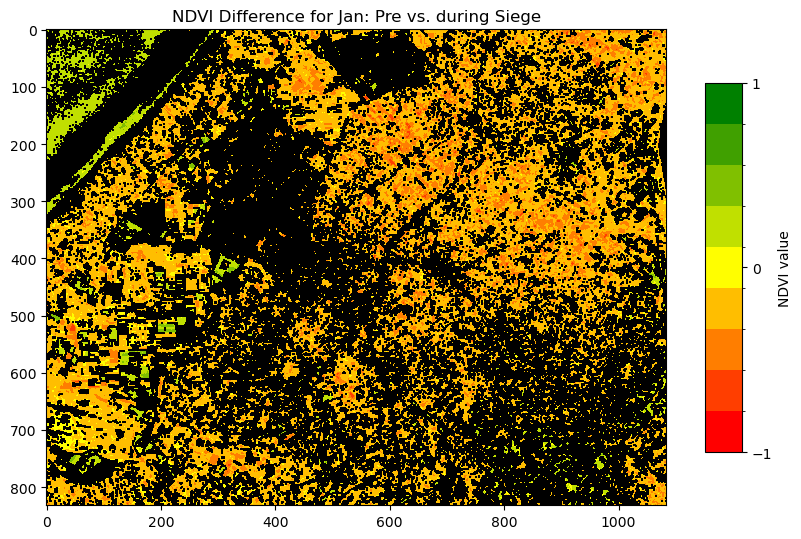

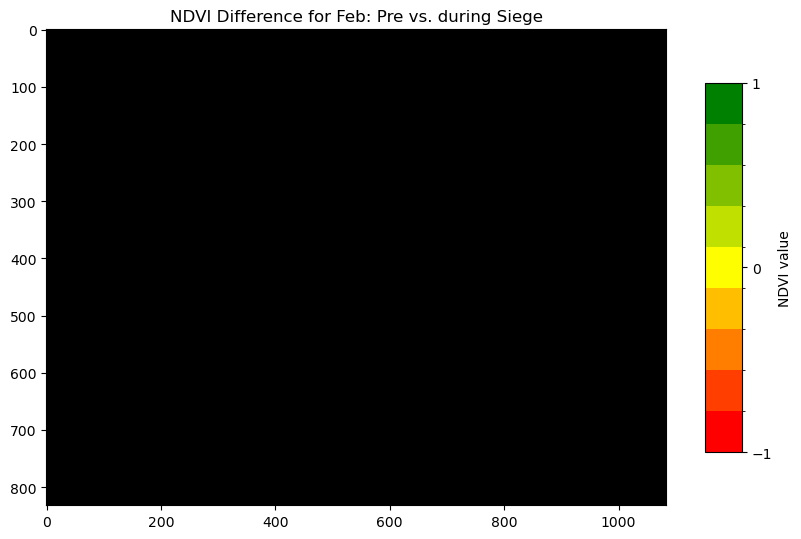

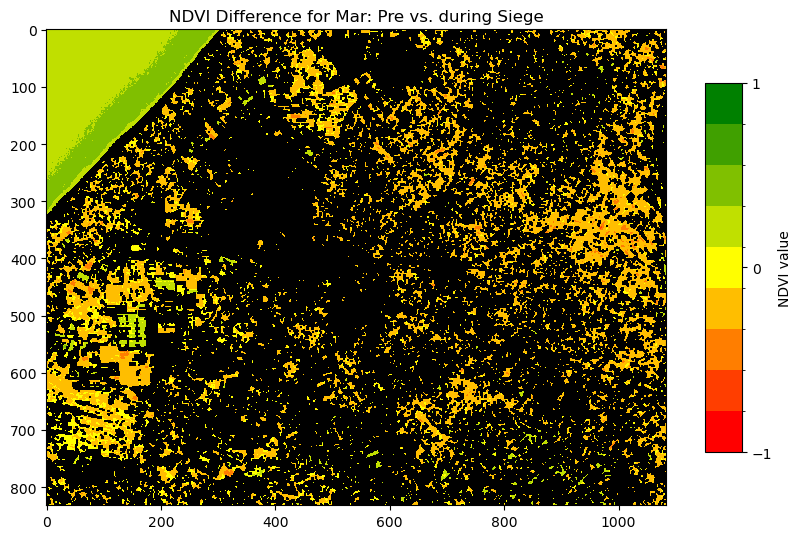

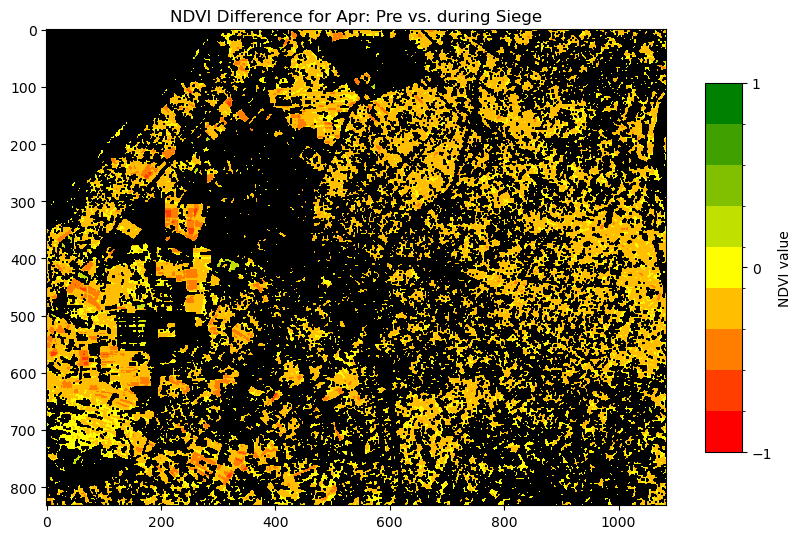

In [43]:
# using the same map setting as previously
# here we use the means of both periods. The siege period just contains 1 value, so the mean is just the actual value itself.
# here we calculate the baseline

for month_str in ['Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr']:
    if ndvi_pre_siege[month_str] and ndvi_siege[month_str]:
        baseline = np.mean(np.array(ndvi_pre_siege[month_str]), axis=0)
        ndvi_siege_mean = np.mean(np.array(ndvi_siege[month_str]), axis=0)
        ndvi_difference = ndvi_siege_mean - baseline
        masked_ndvi_difference = masked_inside(ndvi_difference, -0.05, 0.05)
        ndvi_bounds = np.linspace(-1, 1, 10)
        norm = BoundaryNorm(ndvi_bounds, ncolors=256)
        plt.figure(figsize=(10, 8))
        img = plt.imshow(masked_ndvi_difference, cmap=ndvi_cmap, norm=norm)
        cbar = plt.colorbar(img, spacing='proportional', ticks=MaxNLocator(integer=True), shrink=0.6, aspect=10)
        cbar.set_label('NDVI value')
        cbar.ax.tick_params(labelsize=10)

        plt.title(f'NDVI Difference for {month_str}: Pre vs. during Siege')
        plt.show()
    else:
        print(f"Not enough data to compare for {month_str}.")

This is already very good, but to make it more clear, we can look at more quantitative info too by looking at the % decrease compared to the baseline. 

In [47]:
# use the same loop as before
for month_str in ['Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr']:
    if ndvi_pre_siege[month_str] and ndvi_siege[month_str]:
        baseline = np.mean(np.array(ndvi_pre_siege[month_str]), axis=0)
        ndvi_siege_mean = np.mean(np.array(ndvi_siege[month_str]), axis=0)
        ndvi_difference = ndvi_siege_mean - baseline
        
        if not np.isclose(baseline.mean(), 0): # integrity as / by 0 is a headache
            percent_change = (ndvi_difference.mean() / np.abs(baseline.mean())) * 100
            print(f"In {month_str}, there is an averag NDVI change of {percent_change:.1f}% compared to pre-siege period.")
        else:
            print(f"Average pre-siege NDVI for {month_str} is 0, cannot calculate percentage change.")
    else:
        print(f"Not enough data to compare for {month_str}.")

In Nov, there is an averag NDVI change of nan% compared to pre-siege period.
In Dec, there is an averag NDVI change of -27.4% compared to pre-siege period.
In Jan, there is an averag NDVI change of -32.9% compared to pre-siege period.
In Feb, there is an averag NDVI change of nan% compared to pre-siege period.
In Mar, there is an averag NDVI change of -16.7% compared to pre-siege period.
In Apr, there is an averag NDVI change of -36.2% compared to pre-siege period.
